# ***THIS NOTEBOOK STUDIES THE NETWORK'S LOSS, ITERATIONS, CONVERGENCE AND CPU TIME***
---
---
---
---
---

# IMPORTS AND GLOBAL VARIABLES

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes
import math
import keras
from keras import layers, models, optimizers
from keras.callbacks import History
from scipy import integrate
from scipy import interpolate
from scipy.stats import norm
import time

hbar = 1
omega = 1
m = 1
a = -5.
b = 5.

Using TensorFlow backend.


# DATA GENERATION

In [ ]:
#################
#SECTION : FUNCTION DEFINITION
#################

#W.F. stands for "wave function"

def energy_compute (abscissa,psi):
  #interpolations
  tck_true = interpolate.splrep(abscissa, psi, k=3, s=0)                                         #W.F.
  tck_true_carre = interpolate.splrep(abscissa, psi*psi, k=3, s=0)                               #W.F. squared
  tck_true_x = interpolate.splrep(abscissa, abscissa*abscissa*psi*psi, k=3, s=0)                 #W.F. squared*x^2
  der_true = interpolate.splev(abscissa, tck_true, der=1)                                        #W.F. derivative
  tck_true_der = interpolate.splrep(abscissa,der_true*der_true, k=3,s=0)                         #W.F. derivative spline 1000
  int_true_carre = interpolate.splint(a,b,tck_true_carre)                                        #integral of W.F. squared
  int_true_x = interpolate.splint(a,b,tck_true_x)                                                #integral of W.F. squared*x^2 (<x^2>)
  int_true_der = interpolate.splint(a,b,tck_true_der)                                            #integral of derivative squared
  #energy
  Energy = ((-pow(hbar,2)/(2*m))*(psi[-1]*der_true[-1]-psi[0]*der_true[0] - int_true_der) + 0.5*m*omega*int_true_x ) / int_true_carre
  return Energy

def normalization (abscissa,psi):
  tck_true_carre = interpolate.splrep(abscissa, psi*psi, s=0)                       #W.F. squared
  int_true_carre = interpolate.splint(a,b,tck_true_carre)                           #integral of W.F. squared
  psi = psi*pow(1/int_true_carre,1/2)                                               #new normalized function
  return psi




#################
#SECTION : OPENING FILES
#################
file1 = open("mean_loss.txt", "w")
file2 = open("stand_dev_loss.txt", "w")
file3 = open("total_loss.txt","w")
file4 = open("new_targets.txt","w")
file5 = open("new_energy.txt","w")
file6 = open("energy_time.txt","w")






#################
#SECTION : MINIMIZATION - CONVERGENCE, LOSS, TIME, ITERATIONS STUDY
#################



#Number of points on X and Y axis
pts = 100
#X axis
linx = np.linspace(a,b,pts)


#Parameters of the loops
fits = 5000                                #how many iterations we want per run
runs = 1                                   #how many runs we want to compute the mean of the loss
array_loss = np.zeros((fits,runs))         #loss array
array_fits = np.arange(fits) + 1           #iteration array
list_new_target = []                       #at which iteration do we get a new target
list_new_energy = []                       #energy of each new target
energy_time = []                           #records energy and time




#LOOP TO STUDY THE LOSS OVER THE NUMBER OF RUNS WE CHOSE
for k in range(0,runs):
  print('run #',k+1)


  #constant wave function (first target)
  wave = np.ones_like(linx)
  #normalized
  wave = normalization (linx,wave)
  #its energy
  energy_wave = energy_compute(linx,wave)

  #setup for measurement of time
  time1 = time.clock()


  #INITIALIZATION OF NEURAL NETWORK
  model = models.Sequential([
    layers.Dense(100, input_shape=(1,), activation='relu'),
    layers.Dense(100, input_shape=(1,), activation='relu'),
    layers.Dense(100, input_shape=(1,), activation='relu'),
    layers.Dense(100, input_shape=(1,), activation='relu'),
    layers.Dense(1), # no activation -> linear function of the input
  ])
  opt = optimizers.Adam(learning_rate=0.001)
  model.compile(loss='mse',optimizer=opt)
  history = History()



  #BEGINING OF MINIMIZATION
  for i in range(0,fits):

    #one training
    hist = model.fit(linx,wave,epochs=1,batch_size=50,verbose=0,callbacks=[history])
    #prediction after one training
    predictions = model.predict(linx)

    #prediction is made positive, symetric and normalized
    preds = np.abs(predictions.reshape(-1))
    for j in range(0,pts):
      preds[j] = (preds[j]+preds[pts-1-j])/2
      preds[pts-1-j] = preds[j]
    preds = normalization(linx,preds)
    #energy of prediction
    energy_preds = energy_compute(linx,preds)

    #we choose the function with the lowest energy
    if (energy_preds < energy_wave):
      wave = preds
      energy_wave = energy_preds
      
      if(k==0):
        #we keep the new target (will only work for the first run)
        list_new_target.extend([i+1,hist.history['loss'][0]])
        list_new_energy.extend([energy_wave,hist.history['loss'][0]])
        energy_time.extend([energy_wave,time.clock()-time1])



    #writing the loss
    array_loss[i,k] = hist.history['loss'][0]

  #clear of the network
  keras.backend.clear_session()







#################
#END OF DATA GENERATION
#################

#calculating mean loss and standard deviation over all runs
mean_loss = np.sum(array_loss,axis=1)/runs
stand_dev = np.std(array_loss,1)
#writing data in files
np.savetxt(file1, mean_loss, fmt='%.18e', delimiter=' ', newline='\n')
np.savetxt(file2, stand_dev, fmt='%.18e', delimiter=' ', newline='\n')
np.savetxt(file3,array_loss, fmt='%.18e', delimiter=' ', newline ='\n')
np.savetxt(file4,list_new_target, fmt='%.18e', delimiter=' ', newline ='\n')
np.savetxt(file5,list_new_energy, fmt='%.18e', delimiter=' ', newline ='\n')
np.savetxt(file6,energy_time, fmt='%.18e', delimiter=' ', newline ='\n')
#closing files
file1.close()
file2.close()
file3.close()
file4.close()
file5.close()
file6.close()

run # 1
run # 2
run # 3
run # 4
run # 5
run # 6
run # 7
run # 8
run # 9
run # 10
run # 11
run # 12
run # 13
run # 14
run # 15
run # 16
run # 17
run # 18
run # 19
run # 20
run # 21
run # 22
run # 23
run # 24
run # 25
run # 26
run # 27
run # 28
run # 29
run # 30


# DATA ANALYSIS : PLOTS OVER MULTIPLE RUNS
(check "runs" variable in previous cell)

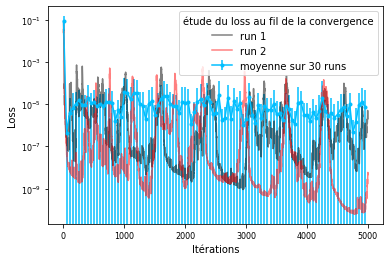

<Figure size 432x288 with 0 Axes>

In [ ]:
#opening files
total_loss = np.loadtxt("total_loss.txt", dtype=float, delimiter=' ')
mean_loss = np.loadtxt("mean_loss.txt", dtype=float, delimiter=' ')
stand_dev = np.loadtxt("stand_dev_loss.txt", dtype=float, delimiter=' ')
list_new_target = np.loadtxt("new_targets.txt", dtype=float, delimiter=' ')
list_new_energy = np.loadtxt("new_energy.txt", dtype=float, delimiter=' ')
energy_time = np.loadtxt("energy_time.txt", dtype=float, delimiter=' ')

#keeping the three first runs
loss_0 = np.reshape(total_loss[:,0],-1)
loss_1 = np.reshape(total_loss[:,1],-1)
loss_2 = np.reshape(total_loss[:,2],-1)

#plot of loss with respect to iteration : 3 runs and mean value
plt.yscale('log')
plt.errorbar(array_fits[0::50],mean_loss[0::50], yerr = stand_dev[0::50],marker='.',c='deepskyblue',label = 'moyenne sur 30 runs')
plt.plot(array_fits,loss_1, c = 'k',alpha=0.5,label='run 1')
plt.plot(array_fits,loss_2,c='r',alpha=0.5,label="run 2")
plt.ylabel('Loss')
plt.xlabel("Itérations")
plt.legend(title = 'étude du loss au fil de la convergence',loc='upper right')
plt.tick_params(axis='both',labelsize='8')
plt.savefig('minimization_loss.pdf')
plt.show()
plt.clf()

# DATA ANALYSIS : PLOTS FOR 1 RUN

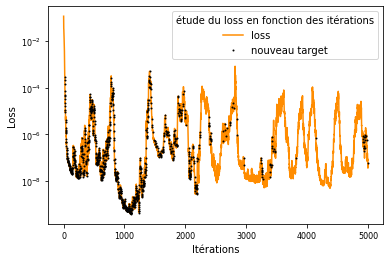

<Figure size 432x288 with 0 Axes>

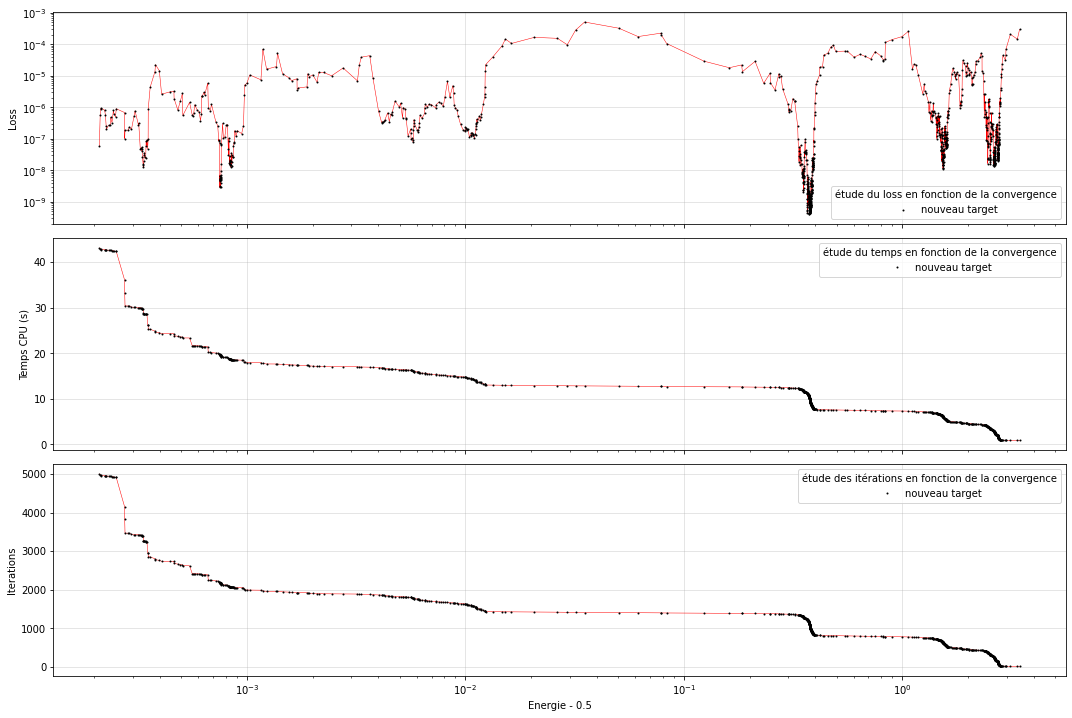

<Figure size 432x288 with 0 Axes>

In [ ]:
#opening files
list_new_target = np.loadtxt("new_targets.txt", dtype=float, delimiter=' ')
list_new_energy = np.loadtxt("new_energy.txt", dtype=float, delimiter=' ')
energy_time = np.loadtxt("energy_time.txt", dtype=float, delimiter=' ')

#keeping the three first runs
loss_0 = np.reshape(total_loss[:,0],-1)

#plot of loss with respect to iteration : 1 run and new targets
#fig = plt.figure(figsize=[15,5])
plt.yscale('log')
plt.plot(array_fits,loss_0,c='darkorange',label="loss")
plt.plot(list_new_target[0::2],list_new_target[1::2],marker='.',ms=2,c='k',linestyle='None',label='nouveau target')
plt.ylabel('Loss')
plt.xlabel("Itérations")
plt.legend(title = 'étude du loss en fonction des itérations')
plt.tick_params(axis='both',labelsize='8')
plt.savefig('minimization_loss_new_target.pdf')
plt.show()
plt.clf()







#multiplot
fig, axs = plt.subplots(3, 1,figsize=(15, 10),sharex=True)

#plot of loss with respect to energy - 0.5 : new targets
axs[0].grid(axis='both',alpha=0.4)
axs[0].plot(list_new_energy[0::2]-0.5,list_new_energy[1::2],c='r',linewidth=0.5)
axs[0].plot(list_new_energy[0::2]-0.5,list_new_energy[1::2],marker='.',ms=2,c='k',linestyle='None',label='nouveau target')
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_ylabel('Loss')
axs[0].legend(title = 'étude du loss en fonction de la convergence')

#plot of time with respect to energy - 0.5 : new targets
axs[1].grid(axis='both',alpha=0.4)
axs[1].plot(energy_time[0::2]-0.5,energy_time[1::2],c='r',linewidth=0.5)
axs[1].plot(energy_time[0::2]-0.5,energy_time[1::2],marker='.',ms=2,c='k',linestyle='None',label='nouveau target')
axs[1].set_xscale('log')
axs[1].set_ylabel('Temps CPU (s)')
axs[1].legend(title = 'étude du temps en fonction de la convergence')

#plot of iterations with respect to energy - 0.5 : new targets
axs[2].grid(axis='both',alpha=0.4)
axs[2].plot(energy_time[0::2]-0.5,list_new_target[0::2],c='r',linewidth=0.5)
axs[2].plot(energy_time[0::2]-0.5,list_new_target[0::2],marker='.',ms=2,c='k',linestyle='None',label='nouveau target')
axs[2].set_xscale('log')
axs[2].set_ylabel('Iterations')
axs[2].set_xlabel("Energie - 0.5")
axs[2].legend(title = 'étude des itérations en fonction de la convergence')

plt.tight_layout()
plt.savefig('minimization_new_targets_multiplot.pdf')
plt.show()
plt.clf()